In [23]:
import pandas as pd
from datetime import date, timedelta
from random import randint
from time import sleep
import os
import numpy as np
import pymysql
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
import joblib

In [47]:
username = "root"
password = "Sp1d3rman"
host = "localhost"
port = "3306"
database = "nhl_optimizer"

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

In [51]:
query = "SELECT * FROM player_data"

df = pd.read_sql(query,engine)
df.head()

,Player,Team,Position,GP,TOI,TOI/GP,Goals/60,Total Assists/60,First Assists/60,Second Assists/60,...,Penalties Drawn/60,Giveaways/60,Takeaways/60,Hits/60,Hits Taken/60,Shots Blocked/60,Faceoffs Won/60,Faceoffs Lost/60,Faceoffs %,Date
0,Jaromir Jagr,FLA,R,82,1393.983333,16.999797,0.69,1.29,0.86,0.43,...,0.90,1.89,1.72,0.90,3.83,0.17,0.04,0.04,2.15,20162017
1,Shane Doan,ARI,R,74,1113.550000,15.047973,0.32,1.13,0.92,0.22,...,0.54,1.83,1.40,5.44,4.15,1.19,5.06,5.66,2.55,20162017
2,Jarome Iginla,"COL, L.A",R,80,1210.166667,15.127083,0.69,0.64,0.50,0.15,...,0.94,1.29,1.19,5.75,3.42,1.04,0.79,0.69,2.64,20162017
3,Matt Cullen,PIT,C,72,1002.133333,13.918519,0.78,1.08,0.60,0.48,...,0.90,1.92,1.20,2.16,4.67,1.62,26.34,25.09,3.07,20162017
4,Zdeno Chara,BOS,D,75,1749.950000,23.332667,0.34,0.65,0.34,0.31,...,0.65,2.13,1.20,4.46,3.33,4.80,0.00,0.03,0.00,20162017


## Goals Model (Testing)

In [52]:
# Remove target-derived features
features_to_exclude = [
    'SH%', 'IPP', 'ixG/60',
    'iCF/60', 'iSCF/60', 'iHDCF/60', 'Rebounds Created/60',
]

X = df.drop(columns=['Player','Position','Goals/60', 'Total Assists/60', 'First Assists/60', 'Second Assists/60', 'Total Points/60'] + features_to_exclude)

y = df['Goals/60']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = ['Position']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

lasso = Lasso(max_iter=10000, random_state=42)


lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lasso)
])


param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}


grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)

print(f"Best alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Best MAE: {-grid_search.best_score_}")

# Retrieve the best model
best_model = grid_search.best_estimator_

Best alpha: 0.001
Best MAE: 0.19284658963028845


In [53]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Mean Absolute Error: {mae}")
print(f"Test Set R^2 Value: {r2}")

Test Set Mean Absolute Error: 0.18576018864679755
Test Set R^2 Value: 0.652009476254416


In [56]:
# Get feature names after preprocessing
numeric_feature_names = numeric_features
# categorical_feature_names = list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
# all_feature_names = numeric_feature_names + categorical_feature_names
all_feature_names = numeric_feature_names

# Get coefficients from the model
coefficients = best_model.named_steps['regressor'].coef_

# Create a DataFrame of features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Filter out features with non-zero coefficients
important_features = feature_importance[feature_importance['Coefficient'] != 0]

# Sort by absolute value of coefficient
important_features['Abs_Coefficient'] = important_features['Coefficient'].abs()
important_features = important_features.sort_values(by='Abs_Coefficient', ascending=False)

print(important_features[['Feature', 'Coefficient']])

               Feature  Coefficient
4               iFF/60     0.175996
3             Shots/60     0.167460
16    Shots Blocked/60    -0.092643
11  Penalties Drawn/60     0.047251
13        Takeaways/60     0.040164
0                   GP     0.035081
8             Minor/60    -0.023596
17     Faceoffs Won/60     0.022121
14             Hits/60    -0.019848
15       Hits Taken/60    -0.017088
18    Faceoffs Lost/60     0.016160
2               TOI/GP     0.014058
12        Giveaways/60    -0.005850
6               PIM/60     0.005207
9             Major/60    -0.004719
5     Rush Attempts/60     0.000149


/tmp/ipykernel_186226/794972122.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_features['Abs_Coefficient'] = important_features['Coefficient'].abs()


/tmp/ipykernel_186226/1950031351.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_combined.corr()


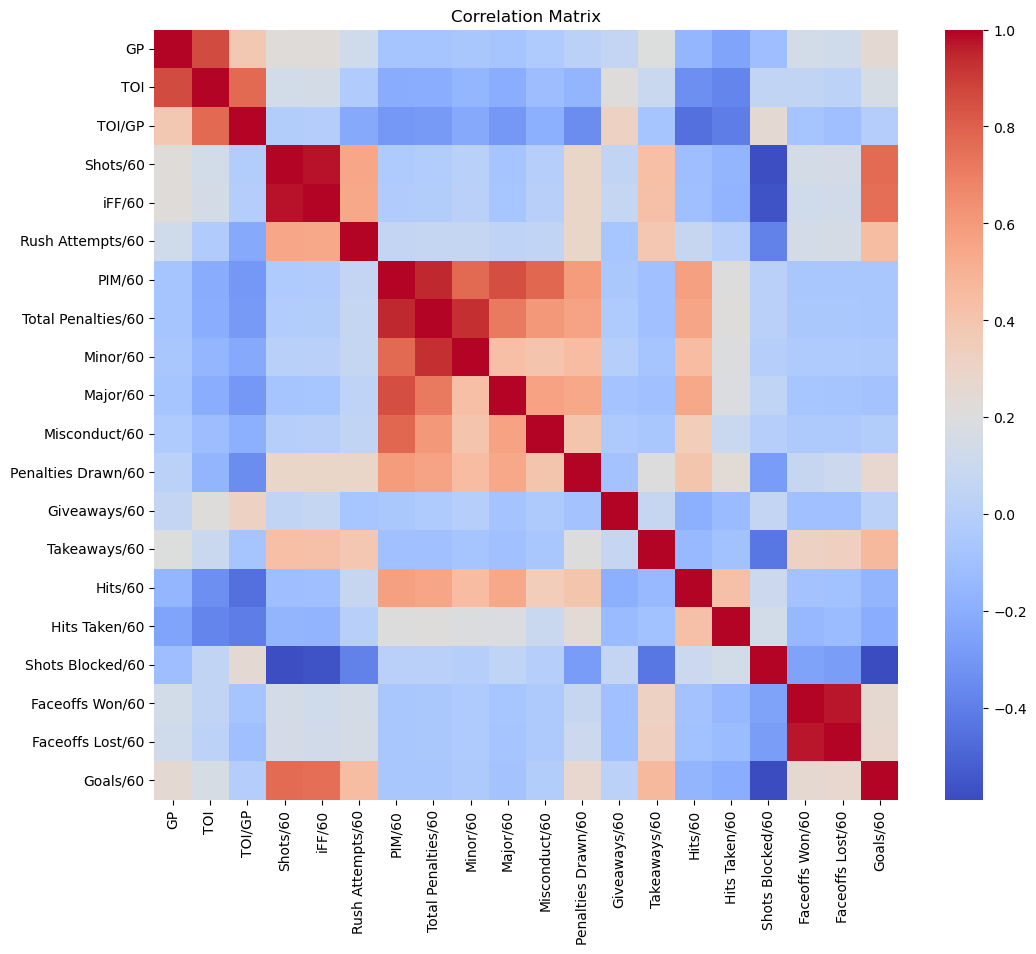

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine X and y for correlation analysis
data_combined = X.copy()
data_combined['Goals/60'] = y

# Compute the correlation matrix
corr_matrix = data_combined.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Create a new pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameters for tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Use GridSearchCV
grid_search_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best MAE: {-grid_search_rf.best_score_}")

# Evaluate on test set
y_pred_rf = grid_search_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test Set MAE: {mae_rf}")
print(f"Random Forest Test Set R^2: {r2_rf}")


Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best MAE: 0.16759161009613116
Random Forest Test Set MAE: 0.16748992022827228
Random Forest Test Set R^2: 0.6984415451167626


In [59]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define hyperparameters for tuning
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [1, 1.5, 2]
}

# Randomized search
random_search_xgb = RandomizedSearchCV(
    xgb_pipeline, param_distributions=param_dist,
    n_iter=50, cv=5, scoring='neg_mean_absolute_error',
    random_state=42, n_jobs=-1
)
random_search_xgb.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {random_search_xgb.best_params_}")
print(f"Best MAE: {-random_search_xgb.best_score_}")

# Evaluate on test set
y_pred_xgb = random_search_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test Set MAE: {mae_xgb}")
print(f"XGBoost Test Set R^2: {r2_xgb}")


Best parameters: {'regressor__subsample': 0.7, 'regressor__reg_lambda': 1, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.8}
Best MAE: 0.16746969976447232
XGBoost Test Set MAE: 0.16534171993146957
XGBoost Test Set R^2: 0.7061847833133148


In [61]:
# Access the best model from the pipeline
best_xgb_model = random_search_xgb.best_estimator_.named_steps['regressor']

# Get feature importances
importances = best_xgb_model.feature_importances_

# Get feature names after preprocessing
numeric_feature_names = numeric_features
# categorical_feature_names = list(best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
# all_feature_names = numeric_feature_names + categorical_feature_names
all_feature_names = numeric_feature_names

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


               Feature  Importance
3             Shots/60    0.344811
4               iFF/60    0.168011
18    Faceoffs Lost/60    0.158345
2               TOI/GP    0.052414
17     Faceoffs Won/60    0.048651
16    Shots Blocked/60    0.029651
1                  TOI    0.022275
9             Major/60    0.019229
14             Hits/60    0.017079
13        Takeaways/60    0.016890
15       Hits Taken/60    0.015990
11  Penalties Drawn/60    0.014426
7   Total Penalties/60    0.014424
5     Rush Attempts/60    0.014037
8             Minor/60    0.013968
12        Giveaways/60    0.013821
6               PIM/60    0.013497
10       Misconduct/60    0.012252
0                   GP    0.010228


## Goals Model

In [4]:
# Split data
X = df.drop(columns=['Player', 'Goals/60', 'Total Assists/60', 'First Assists/60', 'Second Assists/60', 'Total Points/60'])
y = df['Goals/60']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['Team', 'Position']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Initialize the model
ridge = Ridge(alpha=10)



goals_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ridge)
])

# Train model
goals_pipeline.fit(X_train, y_train)
# Make predictions
y_pred = goals_pipeline.predict(X_test)


# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the R^2 value
r2 = r2_score(y_test, y_pred)
print(f"R^2 Value: {r2}")

Mean Absolute Error: 0.06186531705106981
R^2 Value: 0.960389473021189


## Assists Model

In [5]:
# Split data
X = df.drop(columns=['Player', 'Goals/60','Total Assists/60', 'First Assists/60', 'Second Assists/60', 'Total Points/60'])
y = df['Total Assists/60']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['Team', 'Position']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Initialize the model
ridge = Ridge(alpha=10)


assists_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ridge)
])

# Train model
assists_pipeline.fit(X_train, y_train)
# Make predictions
y_pred = assists_pipeline.predict(X_test)


# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the R^2 value
r2 = r2_score(y_test, y_pred)
print(f"R^2 Value: {r2}")

Mean Absolute Error: 0.2144047073437458
R^2 Value: 0.7017067627831388


In [6]:
# Save the pipelines
joblib.dump(goals_pipeline, 'goals_model.pkl')
joblib.dump(assists_pipeline,'assists_model.pkl')

['assists_model.pkl']

In [9]:
# Load the models
loaded_goals_pipeline = joblib.load('goals_model.pkl')
loaded_assists_pipeline = joblib.load('assists_model.pkl')

# Read and process the data
season_totals = pd.read_csv('season_totals_24.csv',index_col=0)
season_totals.drop(columns=["Goals/60","Total Assists/60"], inplace=True)

# Predictions
goal_predictions = loaded_goals_pipeline.predict(season_totals)
assist_predictions = loaded_assists_pipeline.predict(season_totals)

In [10]:
# Create dataframe for reference

num_games = 82  # Standard NHL season

result_df = pd.DataFrame({
    'Team':season_totals['Team'].values,
    'Position':season_totals['Position'].values,
    'Player':season_totals['Player'].values,
    'Projected Goals/60':goal_predictions,
    'Projected Assists/60':assist_predictions,
    'Projected Goals (TOI)':(season_totals['TOI/GP']/60) * goal_predictions,
    'Projected Assists (TOI)':(season_totals['TOI/GP']/60) * assist_predictions,
})


result_df['Projected Goals (Season)'] = (result_df['Projected Goals (TOI)'] * num_games).round(1)

result_df['Projected Assists (Season)'] = (result_df['Projected Assists (TOI)'] * num_games).round(1)

result_df['Projected Pts (Season)'] = ((result_df['Projected Assists (TOI)'] + result_df['Projected Goals (TOI)'] )* num_games).round(1)


result_df = result_df.round(2)

selected = result_df[['Team','Position','Player', 'Projected Goals (Season)','Projected Assists (Season)', 'Projected Pts (Season)']]

## Sort and filter end data
selected = selected.sort_values(by='Projected Pts (Season)', ascending=False)
selected.head(30).round()

,Team,Position,Player,Projected Goals (Season),Projected Assists (Season),Projected Pts (Season)
380,EDM,C,Connor McDavid,54.0,65.0,119.0
293,COL,C,Nathan MacKinnon,46.0,64.0,110.0
340,BOS,R,David Pastrnak,51.0,58.0,109.0
323,EDM,C,Leon Draisaitl,48.0,60.0,107.0
387,COL,R,Mikko Rantanen,48.0,59.0,106.0
435,MIN,L,Kirill Kaprizov,45.0,60.0,106.0
654,N.J,C,Jack Hughes,42.0,54.0,97.0
446,FLA,L,Matthew Tkachuk,41.0,53.0,94.0
10,WSH,L,Alex Ovechkin,42.0,50.0,92.0
551,COL,D,Cale Makar,26.0,66.0,92.0


In [11]:
result_df.to_csv('nhl_predictions.csv',index=False)